# Machine perceptual quality evaluation

* Image Compression Methods
    * jpeg Q = 5
    * webp Q = 0
    * [mbt2018](https://arxiv.org/abs/1809.02736) Q = 1
    * [cheng_2020_anchor](https://arxiv.org/abs/2001.01568) Q = 1
    * [hific](https://hific.github.io/) Q = low
* Image Classification Accuracy
  * Dataset: [ImageNet-1k](https://huggingface.co/datasets/imagenet-1k)
  * Model: [Distilled data-efficient Image Transformer (DeiT)](https://huggingface.co/facebook/deit-small-distilled-patch16-224)
* Image Segmentation Mean Intersection over Union
  * Dataset: [ADE20k](https://huggingface.co/datasets/scene_parse_150)
  * Model: [SegFormer](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512)
* Audio Compression Methods:
    * MP3 Q = 8 kbps
    * OGG (Vorbis) Q = 0
    * Opus Q = 6kbps
    * [EnCodec](https://github.com/facebookresearch/encodec) Q = 48 kHz, 6kbps
* Automatic Speech Recognition Word Error Rate 
  * Dataset: [Common Voice](https://huggingface.co/datasets/mozilla-foundation/common_voice_11_0)
  * Model: [Whisper](https://huggingface.co/openai/whisper-small)

In [1]:
from datasets import load_dataset
import PIL
import torchaudio
import evaluate
from evaluate import evaluator
from transformers import pipeline
from io import BytesIO
import encodec
import torch
import torch.nn.functional as F
import numpy as np
import compressai.zoo
from torchvision import transforms
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import opuspy
import tempfile
import os
import tfci

2023-10-05 12:53:14.321087: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 12:53:14.344866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 12:53:14.673012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [21]:
def jpeg_compress(sample):
    img = sample['image']
    w = img.width
    h = img.height
    with BytesIO() as f:
        img.save(f, format='JPEG',quality=5)
        img = f.getvalue()
    sample['image'] = PIL.Image.open(BytesIO(img))
    sample['bpp'] = 8*len(img)/(w*h)
    return sample

In [22]:
def webp_compress(sample):
    img = sample['image']
    w = img.width
    h = img.height
    with BytesIO() as f:
        img.save(f, format='WEBP',quality=0)
        img = f.getvalue()
    sample['image'] = PIL.Image.open(BytesIO(img))
    sample['bpp'] = 8*len(img)/(w*h)
    return sample

In [23]:
def pad(x, p=2**6):
    h, w = x.size(2), x.size(3)
    pad, _ = compressai.ops.compute_padding(h, w, min_div=p)
    return F.pad(x, pad, mode="constant", value=0)

def crop(x, size):
    H, W = x.size(2), x.size(3)
    h, w = size
    _, unpad = compressai.ops.compute_padding(h, w, out_h=H, out_w=W)
    return F.pad(x, unpad, mode="constant", value=0)

def nn_compress(sample,net):
    img = sample['image']
    w = img.width
    h = img.height
    
    if (img.mode == 'L') | (img.mode == 'CMYK') | (img.mode == 'RGBA'):
        rgbimg = PIL.Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg
    
    x = transforms.ToTensor()(img).unsqueeze(0)
    x = pad(x)
    
    with torch.no_grad():
        compressed = net.compress(x)
        recovered  = net.decompress(compressed['strings'],shape=compressed['shape'])
    recovered['x_hat'].clamp_(0, 1);
    sample['image'] = transforms.ToPILImage()(recovered['x_hat'].squeeze())
    sample['bpp'] = 8*sum(len(str[0]) for str in compressed['strings'])/(w*h)
    return sample

In [24]:
net_mbt2018 = compressai.zoo.mbt2018(quality=1, pretrained=True).eval()
def mbt2018_compress(sample):
    return nn_compress(sample,net_mbt2018)

In [25]:
net_cheng2020_anchor = compressai.zoo.cheng2020_anchor(quality=1, pretrained=True).eval()
def cheng2020_anchor_compress(sample):
    return nn_compress(sample,net_cheng2020_anchor)

In [26]:
def hific_lo_compress(sample):
    input_img = sample['image']
    with tempfile.NamedTemporaryFile('wb', delete=True) as f_input:
        with tempfile.NamedTemporaryFile('wb', delete=True) as f_compressed:
            with tempfile.NamedTemporaryFile('wb', delete=True) as f_output:
                input_img.save(f_input.name, format='png')
                tfci.compress("hific-lo",f_input.name,f_compressed.name)
                size = os.path.getsize(f_compressed.name)
                bpp = size / (input_img.width*input_img.height)
                tfci.decompress(f_compressed.name,f_output.name)
                output_img = PIL.Image.open(f_output.name)
                rgbimg = PIL.Image.new("RGB", output_img.size)
                rgbimg.paste(output_img)
                output_img = rgbimg
                
    sample['image'] = output_img
    sample['bpp'] = bpp
    return sample

In [73]:
imagenet = load_dataset("imagenet-1k", split="validation[:100]")

In [8]:
jpeg = imagenet.map(jpeg_compress)
jpeg_bpp = np.mean(jpeg['bpp'])
print('jpeg bpp:', jpeg_bpp)
print('jpeg CR:', 24/jpeg_bpp)

jpeg bpp: 0.2592755356771014
jpeg CR: 92.5656172585805


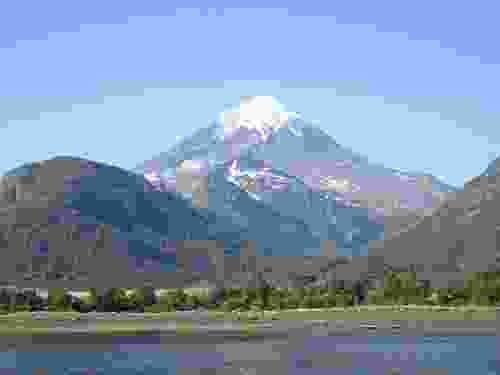

In [29]:
jpeg[2]['image']

In [9]:
webp = imagenet.map(webp_compress)
webp_bpp = np.mean(webp['bpp'])
print('webp bpp:', webp_bpp)
print('webp CR:', 24/webp_bpp)

webp bpp: 0.14186963777366465
webp CR: 169.16938942417696


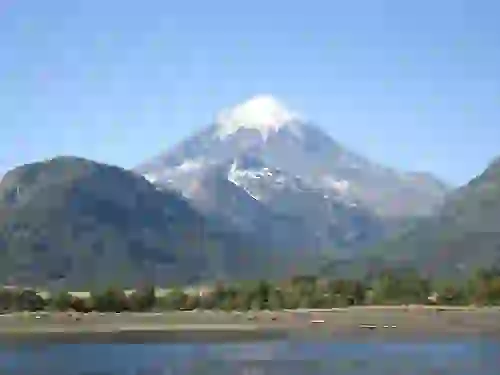

In [30]:
webp[2]['image']

In [10]:
mbt2018 = imagenet.map(mbt2018_compress)
mbt2018_bpp = np.mean(mbt2018['bpp'])
print('mbt2018 bpp:', mbt2018_bpp)
print('mbt2018 CR:', 24/mbt2018_bpp)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

mbt2018 bpp: 0.14164926903281766
mbt2018 CR: 169.43257218249124


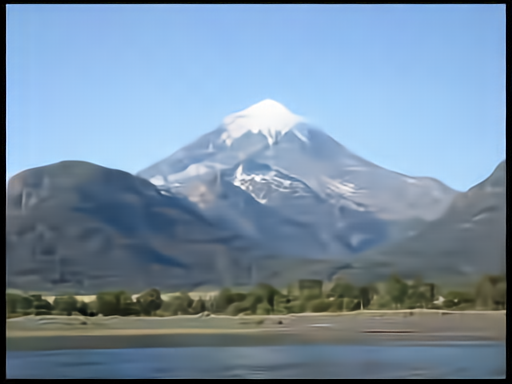

In [26]:
mbt2018[2]['image']

In [21]:
cheng2020_anchor = imagenet.map(cheng2020_anchor_compress)
cheng2020_anchor_bpp = np.mean(cheng2020_anchor['bpp'])
print('cheng2020_anchor bpp:', cheng2020_anchor_bpp)
print('cheng2020_anchor CR:', 24/cheng2020_anchor_bpp)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

cheng2020_anchor bpp: 0.16283093684997987
cheng2020_anchor CR: 147.3921385228643


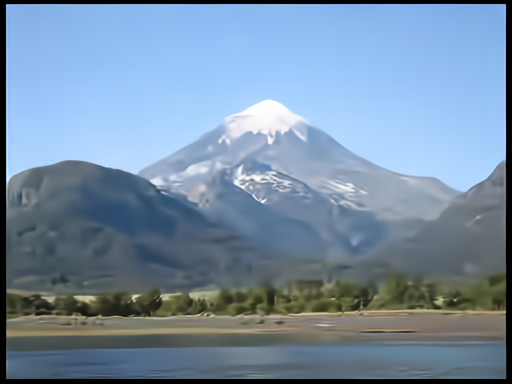

In [27]:
cheng2020_anchor[2]['image']

In [61]:
hific_lo = imagenet.map(hific_lo_compress)
hific_lo_bpp = np.mean(hific_lo['bpp'])
print('hific_lo bpp:', hific_lo_bpp)
print('hific_lo CR:', 24/hific_lo_bpp)

hific_lo bpp: 0.025749013079599294
hific_lo CR: 932.0745585785181


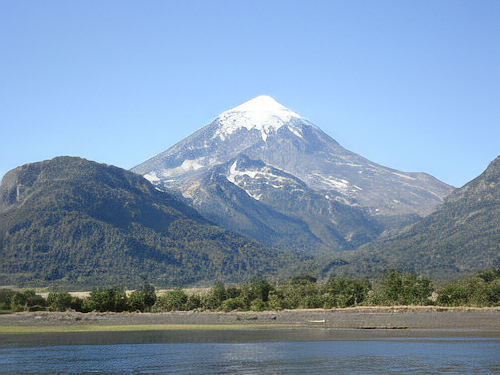

In [62]:
hific_lo[2]['image']

In [63]:
pipe = pipeline(
    task="image-classification",
    model="facebook/deit-small-distilled-patch16-224"
)

task_evaluator = evaluator("image-classification")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


# ImageNet Classification

In [32]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=imagenet,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.81,
 'total_time_in_seconds': 1.91908462299034,
 'samples_per_second': 52.10817636805345,
 'latency_in_seconds': 0.0191908462299034}

In [33]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=jpeg,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.7,
 'total_time_in_seconds': 1.82198002981022,
 'samples_per_second': 54.88534361730416,
 'latency_in_seconds': 0.0182198002981022}

In [34]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=webp,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.73,
 'total_time_in_seconds': 1.9322509551420808,
 'samples_per_second': 51.75311195157198,
 'latency_in_seconds': 0.01932250955142081}

In [35]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=mbt2018,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.75,
 'total_time_in_seconds': 2.3265668470412493,
 'samples_per_second': 42.98178671598127,
 'latency_in_seconds': 0.023265668470412493}

In [36]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=cheng2020_anchor,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.77,
 'total_time_in_seconds': 2.290177895221859,
 'samples_per_second': 43.66473024153985,
 'latency_in_seconds': 0.022901778952218593}

In [64]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=hific_lo,
    metric="accuracy",
    label_mapping=pipe.model.config.label2id
)
eval_results

{'accuracy': 0.8,
 'total_time_in_seconds': 2.5198707710951567,
 'samples_per_second': 39.68457475957752,
 'latency_in_seconds': 0.025198707710951566}

# Image Segmentation

In [65]:
ade20k = load_dataset("scene_parse_150",split='validation[:100]')

In [ ]:
ade20k_jpeg = ade20k.map(jpeg_compress)
ade20k_webp = ade20k.map(webp_compress)
ade20k_mbt2018 = ade20k.map(mbt2018_compress)
ade20k_cheng2020_anchor = ade20k.map(cheng2020_anchor_compress)
ade20k_hific_lo = ade20k.map(hific_lo_compress)

In [67]:
mean_iou = evaluate.load("mean_iou")
extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

/home/dan/.local/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/dan/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [68]:
def evaluate_segmentation_miou(data):
    x = []
    y = []
    for sample in data:
        ground_truth = sample['annotation']
        img = sample['image']
        inputs = extractor(images=img, return_tensors="pt",do_resize=False)
        outputs = model(**inputs)
        logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
        predictions = logits.argmax(dim=1)[0].detach()
        resize = transforms.Resize(
            (ground_truth.height,ground_truth.width),
            antialias=True
        )
        predictions = resize(
            predictions.unsqueeze(0).unsqueeze(0)
        )[0][0]
    
        x.append(np.array(ground_truth))
        y.append(np.array(predictions))
    return mean_iou.compute(
        predictions=y,
        references=x,
        num_labels=150,
        ignore_index=255,
        reduce_labels=True
    )['mean_iou']

In [51]:
uncompressed_miou = evaluate_segmentation_miou(ade20k)
print(uncompressed_miou)

0.21799779760158605


In [46]:
jpeg_miou = evaluate_segmentation_miou(ade20k_jpeg)
print(jpeg_miou)

0.09738179416093537


/home/dan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


In [47]:
webp_miou = evaluate_segmentation_miou(ade20k_webp)
print(webp_miou)

0.14590738082815083


In [48]:
mbt2018_miou = evaluate_segmentation_miou(ade20k_mbt2018)
print(mbt2018_miou)

0.14736583647617557


In [49]:
cheng2020_anchor_miou = evaluate_segmentation_miou(ade20k_cheng2020_anchor)
print(cheng2020_anchor_miou)

0.14625358918253578


In [69]:
hific_lo_miou = evaluate_segmentation_miou(ade20k_hific_lo)
print(hific_lo_miou)

0.20667317144371297


/home/dan/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


# Automatic Speech Recognition

In [3]:
def mp3_compress(sample):
    sample = common_voice[0]
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    with BytesIO() as f:
        torchaudio.save(f, audio, sample_rate=fs, format="mp3", compression=8.0)
        f.seek(0)
        sample['bps'] = len(f.getvalue())/len(audio[0])
        audio = torchaudio.load(f,format="mp3")
    sample['audio']['array'] = audio[0][0]
    return sample

In [4]:
def ogg_compress(sample):
    sample = common_voice[0]
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    with BytesIO() as f:
        torchaudio.save(f, audio, sample_rate=fs, format="ogg",compression=0)
        f.seek(0)
        sample['bps'] = len(f.getvalue())/len(audio[0])
        audio = torchaudio.load(f,format="ogg")
    sample['audio']['array'] = audio[0][0]
    return sample

In [5]:
def opus_compress(sample):
    audio = sample['audio']['array'].unsqueeze(1)
    audio = (2**15*audio.clamp(min=-1.0,max=1.0)).to(torch.int16).numpy()
    fs = sample['audio']['sampling_rate']
    with tempfile.NamedTemporaryFile('wb', delete=True) as f:
        opuspy.write(
            path=f.name,
            waveform_tc=audio,
            sample_rate=fs,
            bitrate=6000,
            signal_type=2,
            encoder_complexity=10
        )
        audio,fs = opuspy.read(f.name)
        audio = torch.tensor(audio).to(torch.float32)/(2**15)
        audio = audio.transpose(0,1)
        sample['bps'] = os.path.getsize(f.name)/len(audio[0])
    sample['audio']['array'] = audio[0]
    return sample

In [6]:
def encodec_compress(sample,model):
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    audio = encodec.utils.convert_audio(audio,fs,model.sample_rate,model.channels)
    with torch.no_grad():
        encoded_frames = model.encode(audio.unsqueeze(0))
        sample['audio']['array'] = model.decode(encoded_frames).mean(dim=[0,1])
        sample['bps'] = (40/8)*sum(fi[0].shape[2] for fi in encoded_frames)/sample['audio']['array'].shape[0]
    return sample

In [7]:
encodec_model_48_6 = encodec.EncodecModel.encodec_model_48khz()
encodec_model_48_6.set_target_bandwidth(6)

In [8]:
def encodec_48_6_compress(sample):
    return encodec_compress(sample, encodec_model_48_6)

In [ ]:
common_voice = load_dataset("mozilla-foundation/common_voice_11_0",
                            "en",
                            split="validation[:300]"
                           ).with_format("torch")
common_voice_mp3 = common_voice.map(mp3_compress)
common_voice_ogg = common_voice.map(ogg_compress)
common_voice_opus = common_voice.map(opus_compress)
common_voice_encodec_48_6 = common_voice.map(encodec_48_6_compress)

These are bytes per sample not bits per sample (oops)

In [12]:
print("mp3 bps:", common_voice_mp3['bps'].mean())
print("ogg bps:", common_voice_ogg['bps'].mean())
print("opus bps:", common_voice_opus['bps'].mean())
print("endodec_48_6 bps:", common_voice_encodec_48_6['bps'].mean())

mp3 bps: tensor(0.0836)
ogg bps: tensor(0.0941)
opus bps: tensor(0.0184)
endodec_48_6 bps: tensor(0.0158)


In [9]:
pipe = pipeline(
    task="automatic-speech-recognition",
    model="openai/whisper-small",
)

task_evaluator = evaluator("automatic-speech-recognition")
task_evaluator.PIPELINE_KWARGS.pop('truncation', None)

True

In [10]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=common_voice.with_format("numpy"),
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

/home/server/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1358: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'wer': 0.17062937062937064,
 'total_time_in_seconds': 1072.4642355789838,
 'samples_per_second': 0.27972960780183137,
 'latency_in_seconds': 3.574880785263279}

In [11]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=common_voice_mp3.with_format("numpy"),
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

{'wer': 0.18181818181818182,
 'total_time_in_seconds': 1180.2576725169783,
 'samples_per_second': 0.2541817833390822,
 'latency_in_seconds': 3.934192241723261}

In [12]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=common_voice_ogg.with_format("numpy"),
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

{'wer': 0.2727272727272727,
 'total_time_in_seconds': 1161.5042562689923,
 'samples_per_second': 0.25828575175752355,
 'latency_in_seconds': 3.8716808542299748}

In [142]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=common_voice_opus.with_format("numpy"),
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

/home/server/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1358: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'wer': 0.2958041958041958,
 'total_time_in_seconds': 1078.9544834860135,
 'samples_per_second': 0.2780469469209902,
 'latency_in_seconds': 3.5965149449533786}

In [187]:
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=common_voice_encodec_48_6.with_format("numpy"),
    input_column="audio",
    label_column="sentence",
    metric="wer",
)
eval_results

/home/server/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1358: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'wer': 0.26223776223776224,
 'total_time_in_seconds': 1081.699045995978,
 'samples_per_second': 0.27734146675129406,
 'latency_in_seconds': 3.6056634866532593}

# Results

In [3]:
import matplotlib.pyplot as plt
import numpy as np
image_compression_names = [
    'JPEG',
    'WEBP',
    'mbt2018',
    'cheng2020-anchor',
    'HiFiC'
]
image_bpp = [
    0.2592755356771014,
    0.14186963777366465,
    0.14164926903281766,
    0.16283093684997987,
    0.025749013079599294,
]
classification_acc = [
    0.7,
    0.73,
    0.75,
    0.77,
    0.8
]
segmentation_miou = [
    0.09738179416093537,
    0.14590738082815083,
    0.14736583647617557,
    0.14625358918253578,
    0.20667317144371297
]
audio_compression_names = [
    'MP3',
    'Vorbis',
    'Opus',
    'EnCodec',
]
audio_bps = np.array([
    0.0836,
    0.0941,
    0.0184,
    0.0158,
])*8
asr_wer = [
    0.18181818181818182,
    0.2727272727272727,
    0.2958041958041958,
    0.26223776223776224,
]

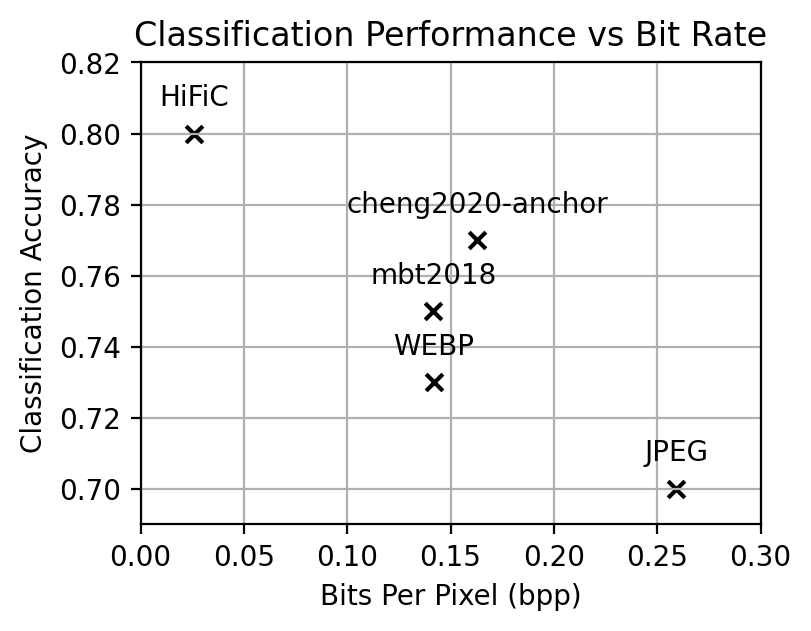

In [66]:
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, classification_acc, c='black', marker='x')
for i, name in enumerate(image_compression_names):
    plt.annotate(name, (image_bpp[i], classification_acc[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Performance vs Bit Rate')
plt.xlim([0,0.3])
plt.ylim([0.69,0.82])
plt.grid(True)
plt.show()

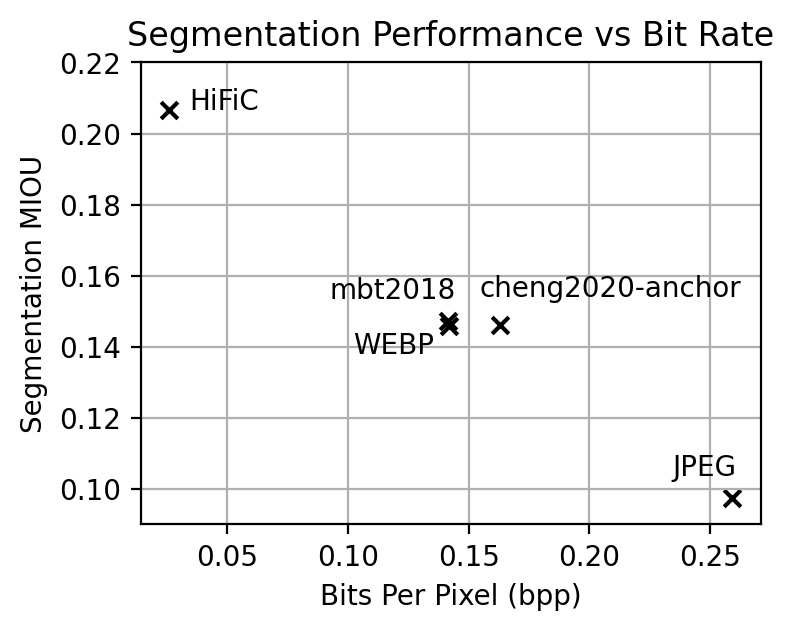

In [65]:
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(image_bpp, segmentation_miou, c='black', marker='x')
offsets = [
    (-10,8),
    (-20,-10),
    (-20,8),
    (40,10),
    (20,0),
]
for i, name in enumerate(image_compression_names):
    plt.annotate(name, (image_bpp[i], segmentation_miou[i]), textcoords="offset points", xytext=offsets[i], ha='center')
    
plt.xlabel('Bits Per Pixel (bpp)')
plt.ylabel('Segmentation MIOU')
plt.title('Segmentation Performance vs Bit Rate')
plt.ylim([0.09,0.22])
plt.grid(True)
plt.show()

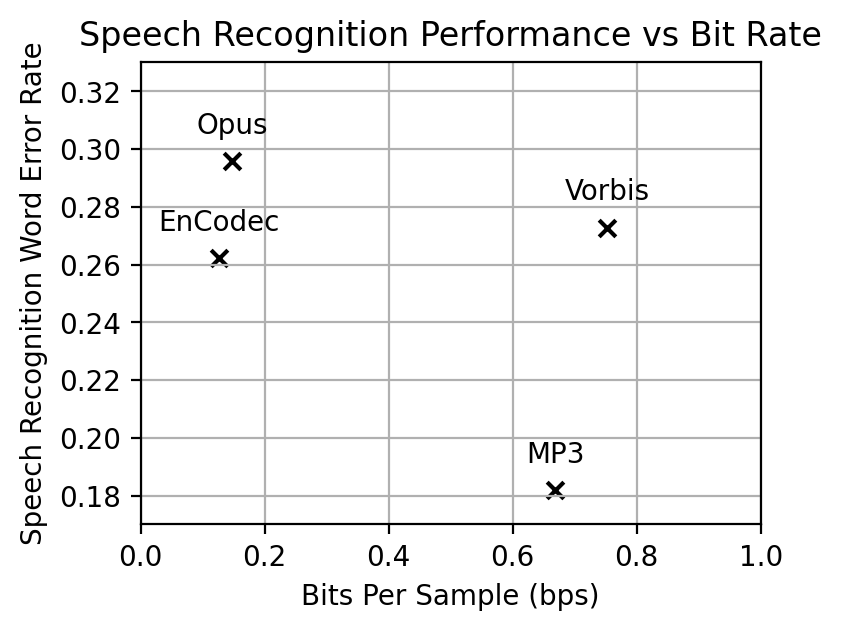

In [70]:
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(audio_bps, asr_wer, c='black', marker='x')
for i, name in enumerate(audio_compression_names):
    plt.annotate(name, (audio_bps[i], asr_wer[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Bits Per Sample (bps)')
plt.ylabel('Speech Recognition Word Error Rate')
plt.title('Speech Recognition Performance vs Bit Rate')
plt.xlim([0,1])
plt.ylim([0.17,0.33])
plt.grid(True)
plt.show()

In [108]:
def blur(sample):
    img = sample['image']
    w = img.width
    h = img.height
    img = img.resize((w//2,h//2)).resize((w,h),resample=PIL.Image.LANCZOS)
    sample['image'] = img
    return sample

def noise(sample):
    prob = 0.015
    img = sample['image']
    img_array = np.array(img)
    noise_mask = np.random.choice([True, False], size=img_array.shape, p=[prob, 1-prob])
    salt_or_pepper = np.random.choice([True, False], size=img_array.shape, p=[0.5, 0.5])
    img_array[noise_mask & salt_or_pepper] = 255  # salt (white)
    img_array[noise_mask & ~salt_or_pepper] = 0  # pepper (black)
    img = PIL.Image.fromarray(np.uint8(img_array))
    sample['image'] = img
    return sample

def distort(sample):
    return noise(sample)

In [118]:
original_distorted = distort(imagenet[2])['image']
jpeg_distorted = jpeg_compress(distort(imagenet[2]))['image']
webp_distorted = webp_compress(distort(imagenet[2]))['image']
mbt2018_distorted = mbt2018_compress(distort(imagenet[2]))['image']
cheng2020_anchor_distorted = cheng2020_anchor_compress(distort(imagenet[2]))['image']
hific_lo_distorted = hific_lo_compress(distort(imagenet[2]))['image']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


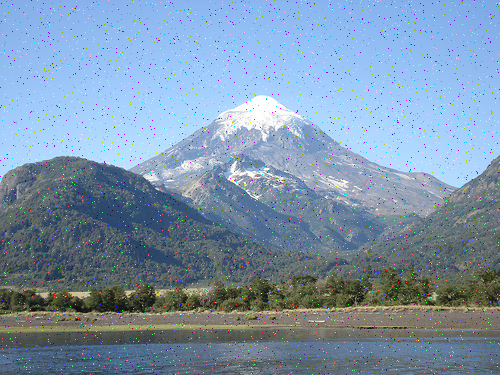

In [119]:
original_distorted

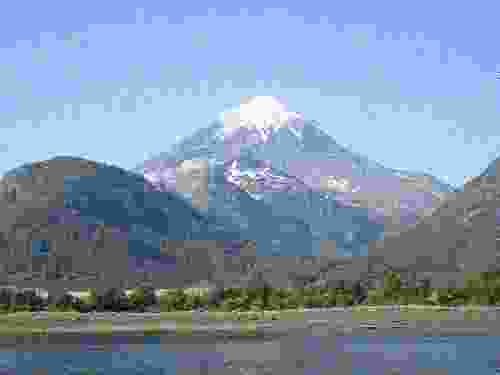

In [120]:
jpeg_distorted

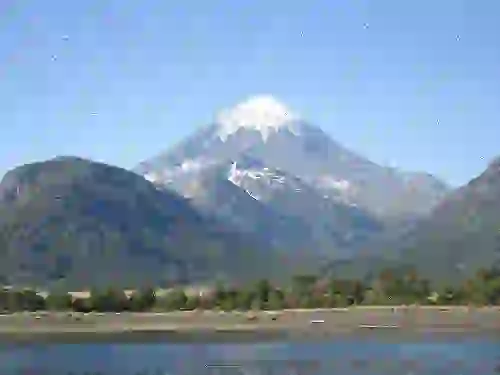

In [121]:
webp_distorted

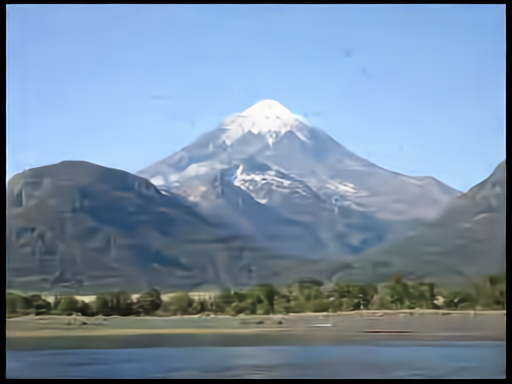

In [122]:
mbt2018_distorted

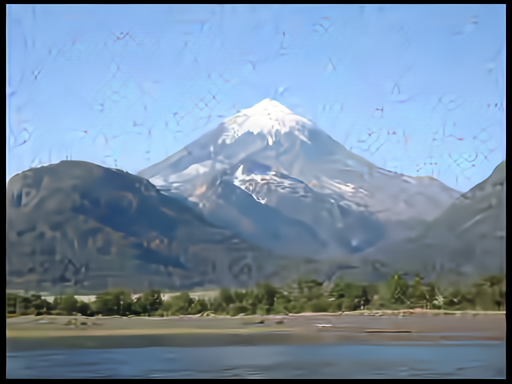

In [123]:
cheng2020_anchor_distorted

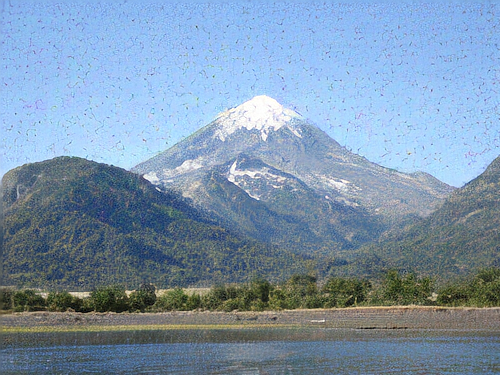

In [124]:
hific_lo_distorted